In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

## Fourier and Bspline basis

In [49]:
class fourier_basis():
    def __init__(self, interval = [0, 1], n = 5):
        """Fourier basis:
        Args:
            interval: range over which we define our basis
            n: numbers of functions in the Fourier basis
        """
        self.type = type
        self.start, self.end = np.min(interval), np.max(interval)
        self.n = n
        self.functions = []
        for i in range(0, self.n+1):
            if i%2 == 1:
                self.functions.append(lambda x, i=i: np.sin(2 * np.pi * ((i//2) + 1) * x / (self.end - self.start)))
            else: 
                self.functions.append(lambda x, i=i: np.cos(2 * np.pi * (i//2) * x / (self.end - self.start)))

    def deriv(self, n):
        """Returns the n-th derivatives of the Fourier basis functions"""
        derivatives = self.functions
        for _ in range(n):
            new_derivatives = []
            for i, fn in enumerate(derivatives):
                freq = 2 * np.pi * ((i // 2) + (1 if i % 2 == 1 else 0)) / (self.end - self.start)
                if i % 2 == 1:  # Sine function
                    new_derivatives.append(lambda x, fn=fn, freq=freq: freq * np.cos(freq * x))
                else:  # Cosine function
                    if i == 0:
                        new_derivatives.append(lambda x, fn=fn: 0 * x)  # Derivative of the constant function is zero
                    else:
                        new_derivatives.append(lambda x, fn=fn, freq=freq: -freq * np.sin(freq * x))
            derivatives = new_derivatives
        new_basis = fourier_basis(interval=[self.start, self.end], n=self.n)
        new_basis.functions = derivatives
        return new_basis

    def integral(self, n=1):
        """Returns the n-th integrals of the Fourier basis functions"""
        integrals = self.functions
        for _ in range(n):
            new_integrals = []
            for i, fn in enumerate(integrals):
                freq = 2 * np.pi * ((i // 2) + (1 if i % 2 == 1 else 0)) / (self.end - self.start)
                if i % 2 == 1:  # Sine function
                    new_integrals.append(lambda x, fn=fn, freq=freq: -1 / freq * np.cos(freq * x))
                else:  # Cosine function
                    if i == 0:
                        new_integrals.append(lambda x, fn=fn: fn(self.start) * (x - self.start))  # Integral of the constant function
                    else:
                        new_integrals.append(lambda x, fn=fn, freq=freq: 1 / freq * np.sin(freq * x))
            integrals = new_integrals
        new_basis = fourier_basis(interval=[self.start, self.end], n=self.n)
        new_basis.functions = integrals
        return new_basis


    def plot(self):
        """Plot method to visualize the basis"""
        values = np.array([fn(np.linspace(self.start, self.end, 100)) for fn in self.functions])
        plt.plot(np.linspace(self.start, self.end, 100), values.T)
        plt.xlim([self.start, self.end])
        plt.show()

    def evaluate(self, x):
        """Evaluating the basis on a given array"""
        return np.array([fn(x) for fn in self.functions])

In [93]:
class bspline_basis():
    def __init__(self, interval = [0, 1], n = 5, order = 4, breaks = None):
        """Bspline basis:
        Args:
            interval: range over which we define our basis
            n: numbers of functions in the bspline basis
            order: order of each bspline (4 is cubic)
            breaks: where to put the breaks (if given)
        """
        self.type = type
        self.start, self.end = np.min(interval), np.max(interval)
        self.n = n
        self.order = order
        self.functions = []
        if breaks is None:
            n_breaks = max(2, self.n - self.order + 2)  # Ensure at least two breaks
            self.breaks = np.linspace(self.start, self.end, n_breaks)
        else:
            self.breaks = np.array(breaks)
        self.knots = self.compute_knots(self.order)
        self.functions = [self.basis_function(i, self.order) for i in range(len(self.knots) - self.order)]

    def compute_knots(self, order):
        """Create the sequence of knots needed for the bsplines of order order"""
        t_start = np.repeat(self.start, order)
        t_end = np.repeat(self.end, order)
        internal_knots = self.breaks[1:-1]
        return np.concatenate([t_start, internal_knots, t_end])

    def basis_function(self, i, k):
        """Cox-de Boor recursion implementation"""
        if k == 1:
            def b(x):
                # Handling the discontinuity for the last spline
                if i == len(self.knots) - self.order - 1:
                    return np.where((self.knots[i] <= x) & (x <= self.knots[i + 1]), 1.0, 0.0)
                else:
                    return np.where((self.knots[i] <= x) & (x < self.knots[i + 1]), 1.0, 0.0)
            return b
        else:
            def b(x):
                left = np.zeros_like(x, dtype=float)
                right = np.zeros_like(x, dtype=float)
                if self.knots[i + k - 1] != self.knots[i]:
                    left = ((x - self.knots[i]) / (self.knots[i + k - 1] - self.knots[i])) * self.basis_function(i, k - 1)(x)
                if self.knots[i + k] != self.knots[i + 1]:
                    right = ((self.knots[i + k] - x) / (self.knots[i + k] - self.knots[i + 1])) * self.basis_function(i + 1, k - 1)(x)
                return left + right
            return b

    def derivative(self):
        """Return a new bspline_basis object representing the nth derivative"""
        def derivative_basis_function(i, k):
            if self.order == 1:
                return lambda x: np.zeros_like(x, dtype=float)  # Higher order derivatives of zero order are zero
            if k == 1:
                return self.basis_function(i, k)  # Base case
            else:
                def b(x):
                    left = np.zeros_like(x, dtype=float)
                    right = np.zeros_like(x, dtype=float)
                    if self.knots[i + k] != self.knots[i]:
                        left = ((k) / (self.knots[i + k] - self.knots[i])) * self.basis_function(i, k - 1)(x)
                    if i + k + 1 < len(self.knots) and self.knots[i + k + 1] != self.knots[i + 1]:
                        right = ((-k) / (self.knots[i + k + 1] - self.knots[i + 1])) * self.basis_function(i + 1, k - 1)(x)
                    return left + right
                return b

        new_basis = bspline_basis(interval=[self.start, self.end], n=self.n, order=self.order - 1)
        new_basis.functions = [derivative_basis_function(i, self.order) for i in range(len(self.knots) - self.order)]
        return new_basis
    
    def deriv(self, n):
        new_basis = self.derivative()
        if n > 1:
            for _ in range(n - 1):
                new_basis = new_basis.derivative()
        return new_basis

    def integrate(self):
        """Return a new bspline_basis object representing the nth integral"""
        def integral_basis_function(i, k, new_basis):
            def b(x):
                left = np.zeros_like(x, dtype=float)
                right = np.zeros_like(x, dtype=float)
                if i + k + 1 < len(self.knots):
                    left = ((x - self.knots[i]) / (k + 1)) * new_basis.basis_function(i, k + 1)(x)
                if i + k + 2 < len(self.knots):
                    right = ((self.knots[i + 1] - x) / (k + 1)) * new_basis.basis_function(i + 1, k + 1)(x)
                return left + right
            return b

        new_basis = bspline_basis(interval=[self.start, self.end], n=self.n, order=self.order + 1)
        new_basis.functions = [integral_basis_function(i, self.order, new_basis) for i in range(len(self.knots) - self.order)]
        return new_basis
    
    def integral(self, n):
        new_basis = self.integrate()
        if n > 1:
            for _ in range(n - 1):
                new_basis = new_basis.integrate()
        return new_basis
    
    def plot(self):
        """Plot method to visualize the basis"""
        values = np.array([fn(np.linspace(self.start, self.end, 100)) for fn in self.functions])
        plt.plot(np.linspace(self.start, self.end, 100), values.T)
        for br in self.knots[self.order:-self.order]:
            plt.axvline(br, c='r', linestyle = 'dashed', alpha=0.5)
        plt.xlim([self.start, self.end])
        plt.show()

    def evaluate(self, x):
        """Evaluating the basis on a given array"""
        return np.array([fn(x) for fn in self.functions])

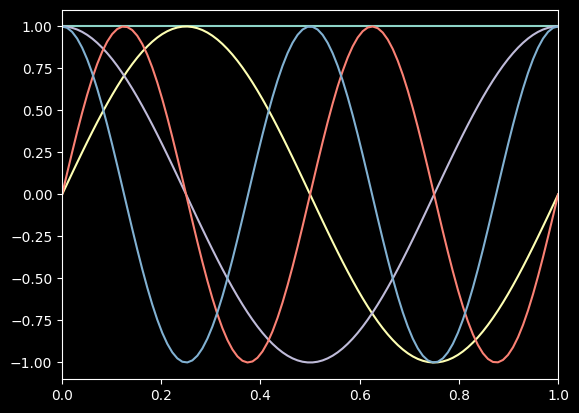

In [47]:
fourier_basis(n=4).plot()

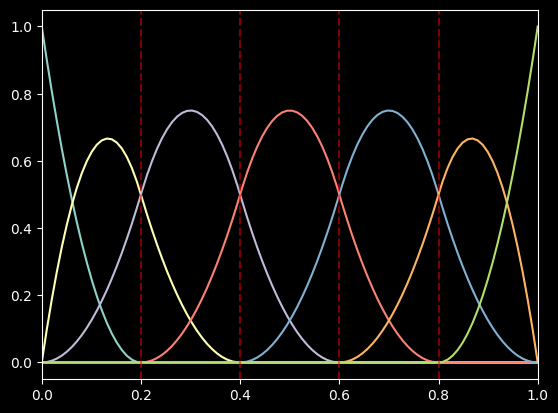

In [96]:
# Plotting 10 cubic splines
bspline_basis(n = 7, order = 3).plot()

## Smoothing functions on the Canadian weather data

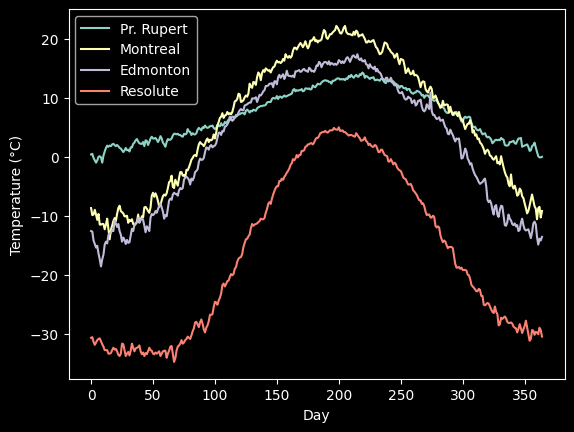

In [6]:
data = pd.read_table('can_weather.tsv')
stations = data.columns
temp = data.values
plt.plot(np.arange(len(temp)),temp)
plt.legend(stations)
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
plt.show()

In [7]:
def ols_fit(input, targets, base_type = 'fourier', n = 5, lbd = 0.001):
    if base_type == 'fourier':
        X = fourier_basis(n=n, interval=input).evaluate(input).T
    elif base_type == 'bspline':
        X = bspline_basis(n=n, interval=input).evaluate(input).T
    y = targets
    b = np.linalg.solve(X.T @ X + lbd * np.eye(X.shape[1]), X.T @ y)
    return X @ b

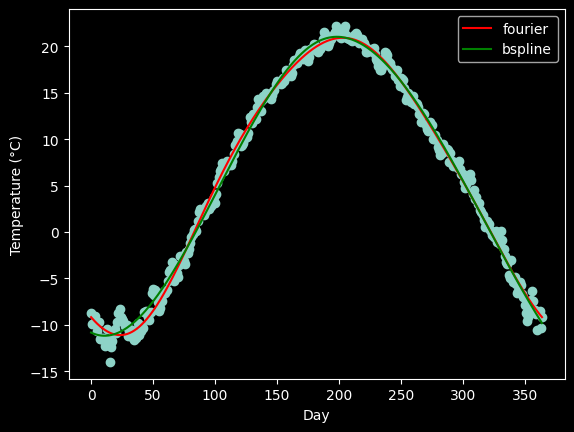

In [8]:
# Comparing bsplines and fourier basis smoothing
montreal = temp[:,1]
day = np.arange(len(montreal))
plt.scatter(day, montreal)
for j in [['fourier','r'], ['bspline','g']]:
    plt.plot(day, ols_fit(day, montreal, base_type=j[0]), c=j[1], label=j[0])
plt.legend()
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
plt.show()

## Speed (derivative)

In [19]:
def ols_fit_speed(input, targets, base_type = 'fourier', n = 5, lbd = 0.001):
    if base_type == 'fourier':
        X = fourier_basis(n=n, interval=input).evaluate(input).T
        derivatives = fourier_basis(n=n, interval=input).deriv(n=1).evaluate(input).T
    elif base_type == 'bspline':
        X = bspline_basis(n=n, interval=input).evaluate(input).T
        derivatives = bspline_basis(n=n, interval=input).deriv(n=1).evaluate(input).T
    y = targets
    b = np.linalg.solve(X.T @ X + lbd * np.eye(X.shape[1]), X.T @ y)
    return derivatives @ b

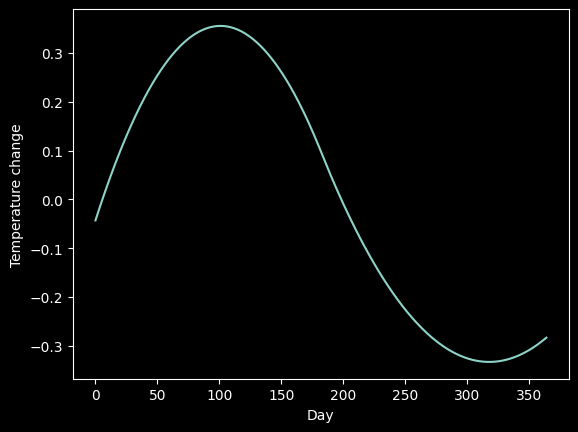

In [56]:
plt.plot(day, ols_fit_speed(day, montreal, base_type='bspline'))
plt.xlabel('Day')
plt.ylabel('Temperature change')
plt.show()

## Confidence interval

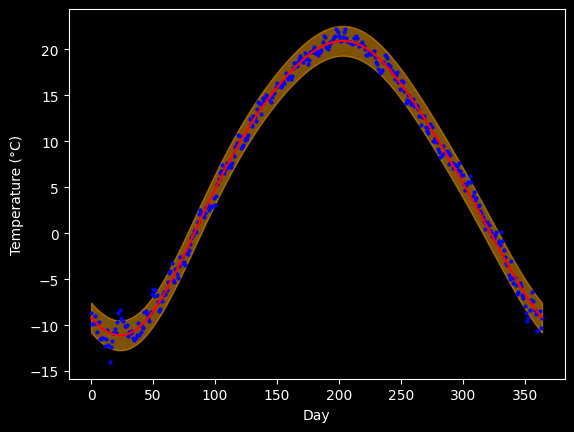

In [11]:
nbasis = 5
fourier_pred = ols_fit(day, montreal, base_type='fourier', n = nbasis)
# Estimating the 95% confidence interval
var = np.sum((fourier_pred - montreal) ** 2) / (365 - nbasis)
plt.fill_between(day, fourier_pred - 2 * np.sqrt(var), fourier_pred + 2 * np.sqrt(var), alpha = 0.5, color='orange')
plt.plot(day, fourier_pred, c='r')
plt.scatter(day, montreal, s=4, c='b')
plt.xlabel('Day')
plt.ylabel('Temperature (°C)')
plt.show()

## Number of components in the Fourier basis

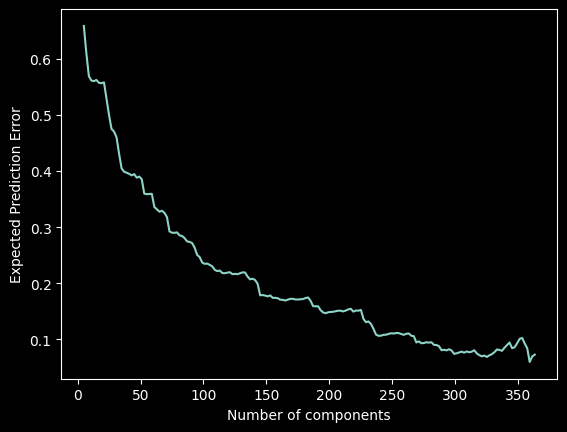

In [12]:
comp = np.arange(5, 364, 2).astype(int)
err = np.zeros(len(comp))
for i, k in enumerate(comp):
    pred = ols_fit(day, montreal, base_type='fourier', n = k)
    err[i] = np.sum((pred - montreal) ** 2) / (365 - k)
plt.plot(comp, err)
plt.xlabel('Number of components')
plt.ylabel('Expected Prediction Error')
plt.show()

## Optimal lambda parameter 

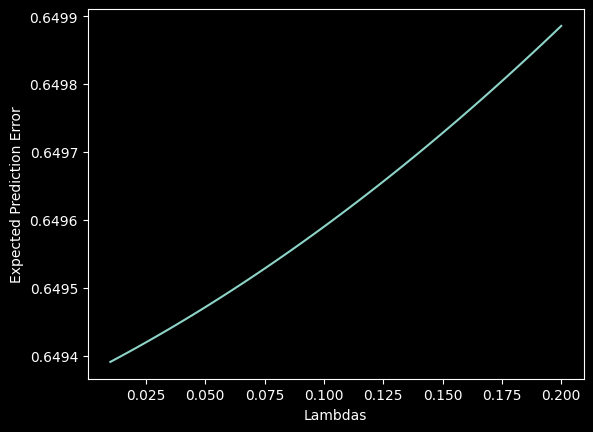

In [13]:
# Right now it's only ridge regression but we should evaluate the roughness too
lambdas = np.linspace(0.01, 0.2, 50)
err_lbd = np.zeros(len(lambdas))
for i, k in enumerate(lambdas):
    pred = ols_fit(day, montreal, base_type='fourier', lbd=k)
    err_lbd[i] = np.sum((pred - montreal) ** 2) / (365 - k)
plt.plot(lambdas, err_lbd)
plt.xlabel('Lambdas')
plt.ylabel('Expected Prediction Error')
plt.show()